In [1]:
import seaborn as sns
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from tabulate import tabulate

from hbn.visualization import visualize as vis

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## GET DATA

from hbn.data import make_dataset

# HARDCODE PARTICIPANTS + FEATURE_SPEC
participants = make_dataset.get_participants(
                            split='all', 
                            disorders=['ADHD-Combined_Type', 
                                        'ADHD-Inattentive_Type', 
                                        'ADHD-Hyperactive_Impulsive_Type', 
                                        'Other_Specified_Attention-Deficit_Hyperactivity_Disorder',
                                        'No_Diagnosis_Given']
                                        )

# get summary of clinical diagnosis + other demographics
df_all = make_dataset.make_summary(save=False)
df_all['Age'] = df_all['Age'].round()
#df_all = make_dataset._add_race_ethnicity(dataframe=df_all)
df_CGAS = make_dataset.add_CGAS_Score(df_all)

# get participants
df_part = pd.DataFrame(participants, columns=['Identifiers'])

# filter large dataframe to include only ADHD + No Diagnosis
df = df_all.merge(df_part, on='Identifiers')
df_CGAS = df_CGAS.merge(df_part, on='Identifiers')

In [3]:
## summary stats

sample_size = len(df_all['Identifiers'].unique())
print(f'total sample size of healthy brain network dataset is {sample_size}\n')

num_ADHD = len(df[df['DX_01_Cat_new']=='ADHD'])
num_no_diagnosis = len(df[df['DX_01_Cat_new']=='No Diagnosis Given'])
print(f'there are {num_ADHD} participants with ADHD and {num_no_diagnosis} with No Diagnosis\n')

# print out summaries
for diagnosis in ['ADHD', 'No Diagnosis Given']:
    print(f'PARTICIPANTS WITH {diagnosis}')
    
    tmp = df[df['DX_01_Cat_new']==diagnosis]
    
    sex = tmp['Sex'].value_counts()
    print(f'1. there are {sex.male} males and {sex.female} females\n')

    ages_6_10 = len(tmp[tmp['Age'].round()<=10])
    ages_10_21 = len(tmp[tmp['Age'].round()>10])
    print(f'2. there are {ages_6_10} children ages 6-10 and {ages_10_21} children ages 11-21\n')

    num_sites = len(tmp['Site'].unique())
    sites = tmp['Site'].value_counts()
    site_numbers = sites.index.tolist()
    site_count = sites.tolist()
    print(f'3. there are {num_sites} study sites and following # of participants collected across the following sites are {site_count}: {site_numbers}\n')

    years = tmp['Enroll_Year'].value_counts().index.astype(str).str.strip('.0').astype(int).tolist()
    num_years = len(tmp['Enroll_Year'].unique())
    print(f'4. data were collected across {num_years} years: {years}\n')

    num_subtypes = len(tmp['DX_01'].unique())
    subtypes = tmp['DX_01'].unique()
    print(f'5. there are {num_subtypes} unique subtypes: {subtypes}\n')

    comorbid = round((tmp['comorbidities'].value_counts() / len(tmp)) * 100)
    num_comorbid = comorbid[1:].sum()
    print(f'6. approximately {num_comorbid}% have disorder combordities\n')

    disorder_cat = round((tmp['DX_01'].value_counts() / len(tmp)) * 100).head(1)
    print(f'7. most prevalent subtype is {disorder_cat.index[0]} - {disorder_cat.values[0]}% of sample\n')

    disorder = round((tmp['DX_01_Cat_new'].value_counts() / len(tmp)) * 100).head(1)
    print(f'8. most prevalent category of diagnosis is {disorder.index[0]} - {disorder.values[0]}% of sample\n')

    tmp_CGAS = df_CGAS[df_CGAS['DX_01_Cat_new']==diagnosis]
    
    sex = tmp_CGAS.groupby(['Sex']).agg({'CGAS_Score': 'mean'})
    f_cgas = sex.loc['male'].values[0]
    m_cgas = sex.loc['female'].values[0]
    print(f'9. females have an average general functioning score (CGAS) of {round(f_cgas)}% and males {round(m_cgas)}%\n')



total sample size of healthy brain network dataset is 4767

there are 1905 participants with ADHD and 373 with No Diagnosis

PARTICIPANTS WITH ADHD
1. there are 1370 males and 535 females

2. there are 1235 children ages 6-10 and 670 children ages 11-21

3. there are 5 study sites and following # of participants collected across the following sites are [842, 537, 471, 42, 13]: [1, 4, 3, 5, 2]

4. data were collected across 8 years: [2018, 2019, 2017, 202, 2016, 2021, 2015, 2022]

5. there are 4 unique subtypes: ['ADHD-Combined Type' 'ADHD-Inattentive Type'
 'Other Specified Attention-Deficit/Hyperactivity Disorder'
 'ADHD-Hyperactive/Impulsive Type']

6. approximately 69.0% have disorder combordities

7. most prevalent subtype is ADHD-Combined Type - 45.0% of sample

8. most prevalent category of diagnosis is ADHD - 100.0% of sample

9. females have an average general functioning score (CGAS) of 64% and males 65%

PARTICIPANTS WITH No Diagnosis Given
1. there are 198 males and 175 fema

## Descriptive Statistics

<Figure size 672x480 with 0 Axes>

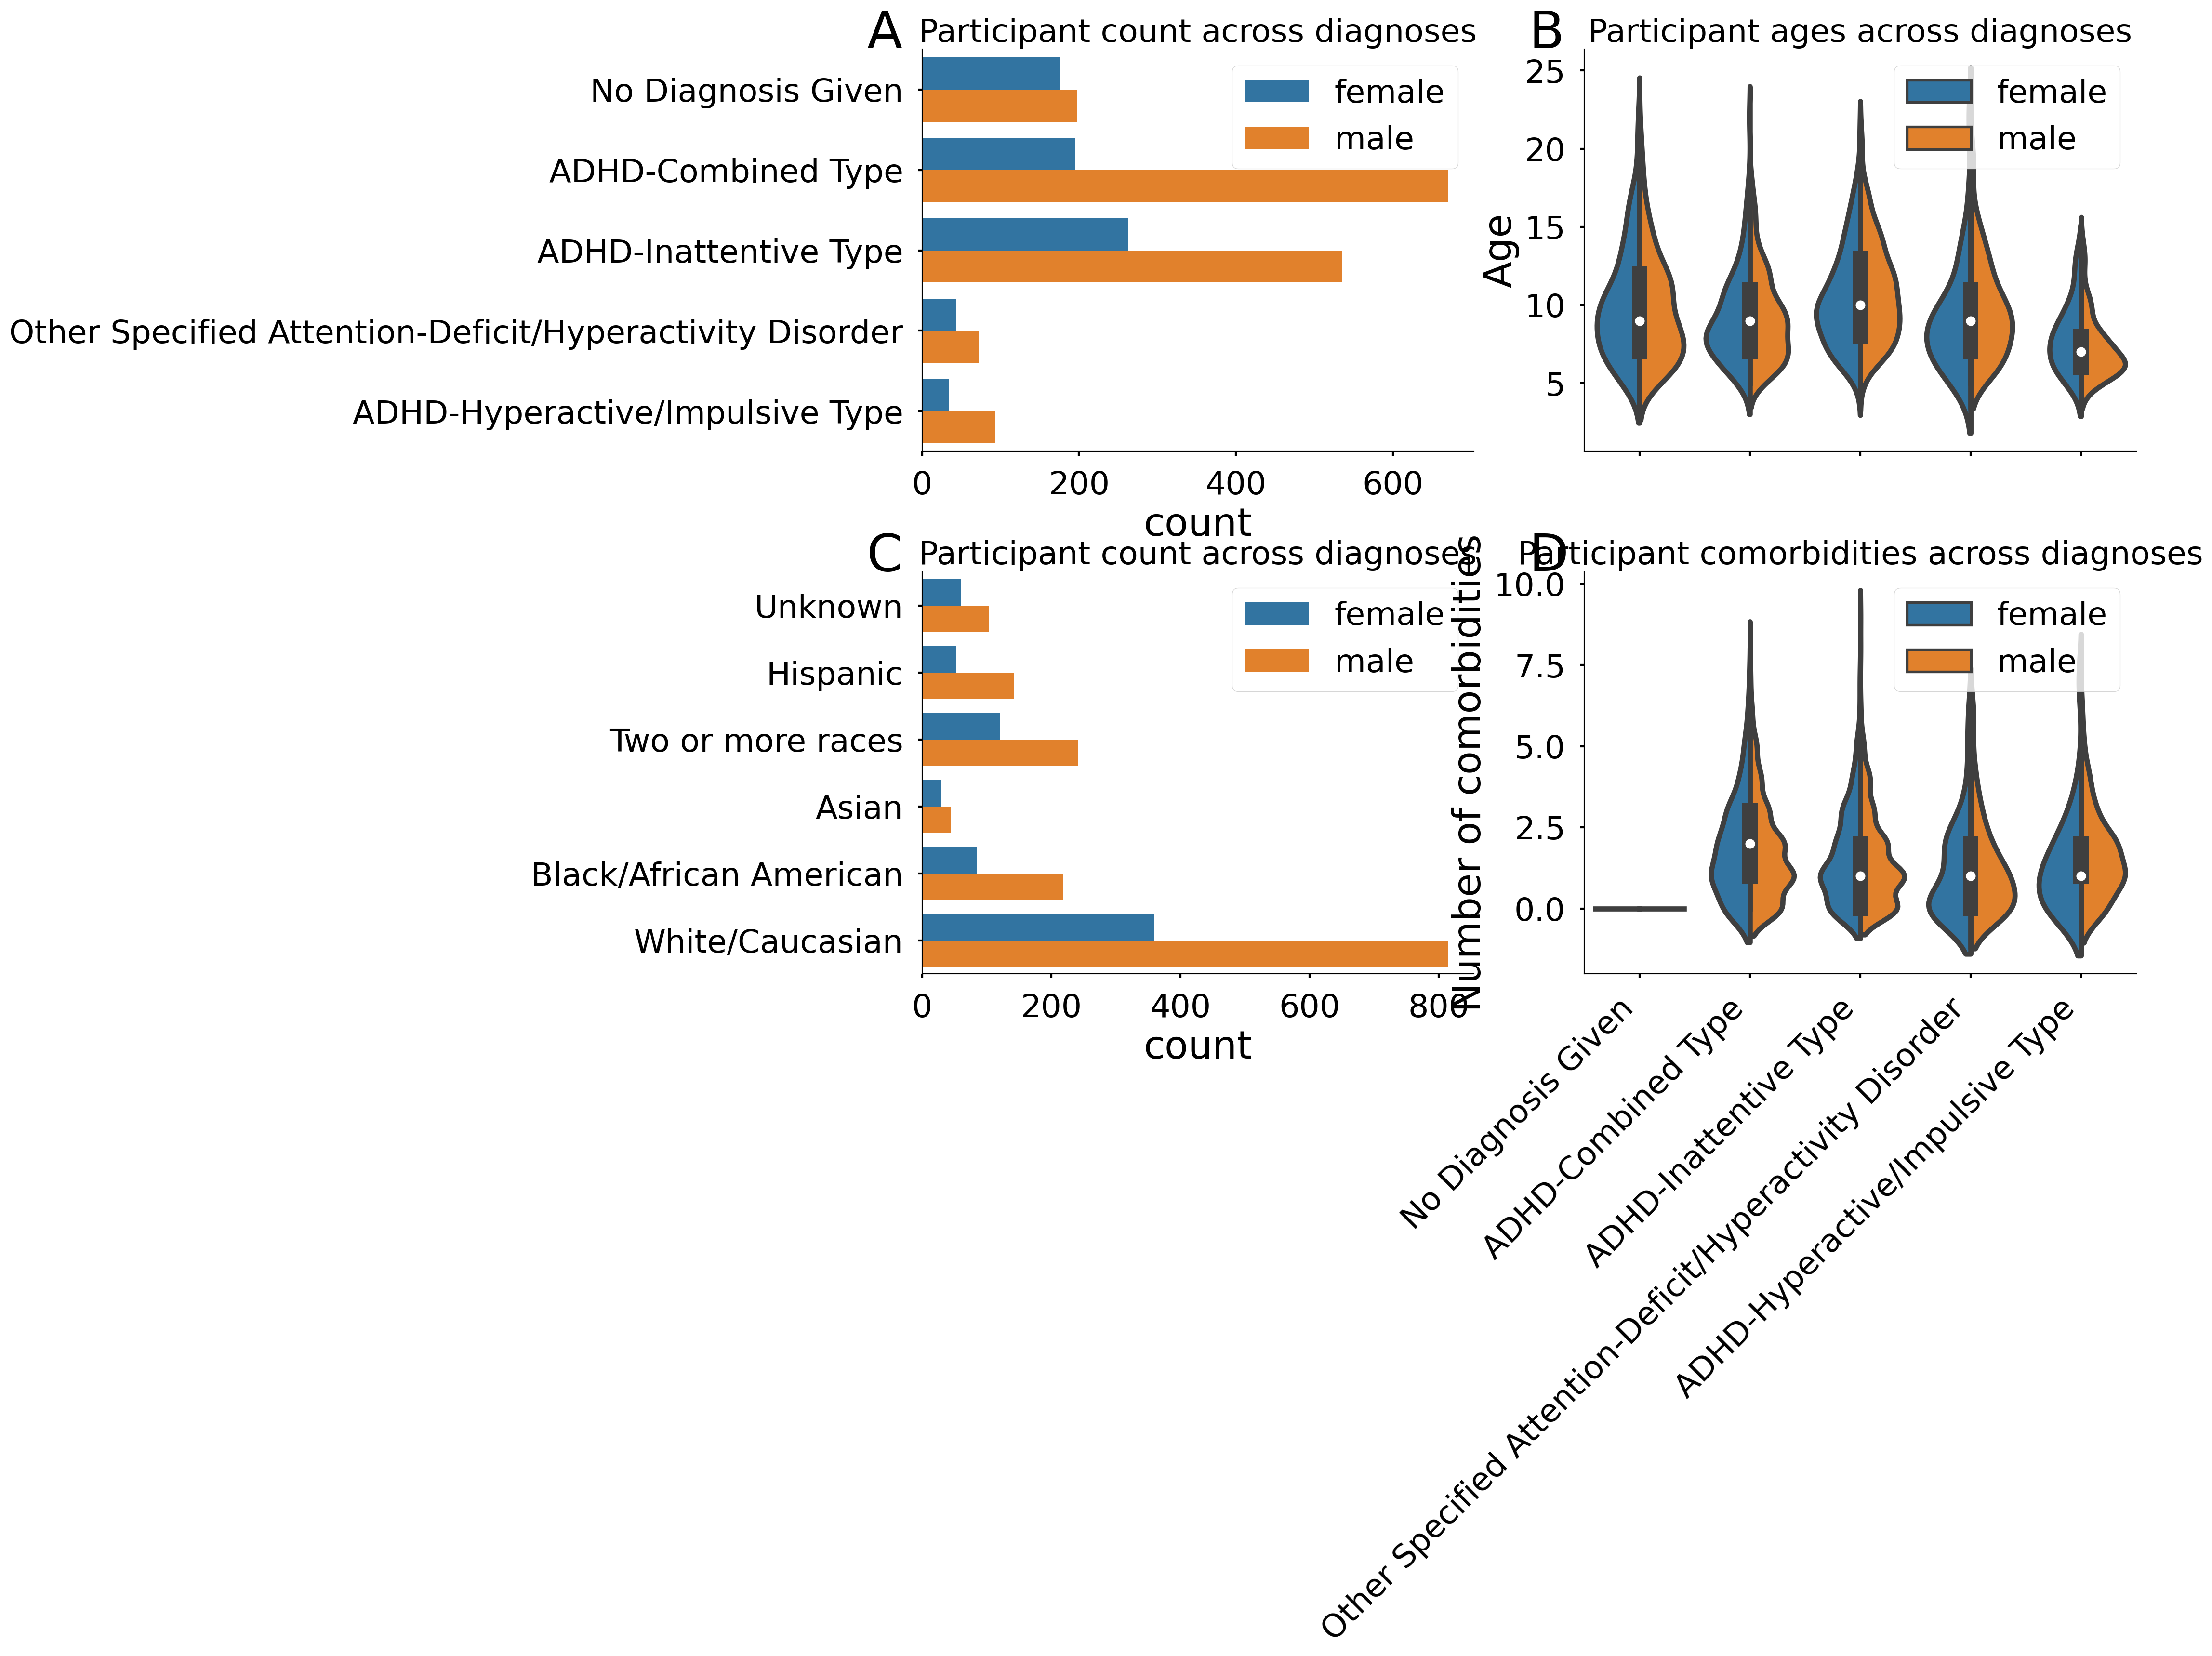

In [4]:
plt.clf()
#vis.plotting_style()
x_pos = -0.1
y_pos = 1.1
labelsize = 40

fig = plt.figure()
gs = GridSpec(2, 2, figure=fig)

ax = fig.add_subplot(gs[0,0])
ax = sns.countplot(data=df, y='DX_01', hue='Sex', ax=ax)
ax.set_ylabel('')
ax.set_title('Participant count across diagnoses')
ax.text(x_pos, y_pos, 'A', transform=ax.transAxes, fontsize=labelsize, verticalalignment='top')
ax.legend_.set_title(None)

ax = fig.add_subplot(gs[0,1])
ax = sns.violinplot(x='DX_01', y='Age', hue='Sex', split=True, data=df, ax=ax)
plt.xticks(rotation=45, ha='right');
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_title('Participant ages across diagnoses')
ax.text(x_pos, y_pos, 'B', transform=ax.transAxes, fontsize=labelsize, verticalalignment='top')
ax.legend_.set_title(None)

ax = fig.add_subplot(gs[1,0])
tmp = df[df['PreInt_Demos_Fam,Child_Race_cat'].isin(['Unknown', 'Hispanic', 'Two or more races', 'Asian',
       'Black/African American', 'White/Caucasian'])]
ax = sns.countplot(data=tmp, y='PreInt_Demos_Fam,Child_Race_cat', hue='Sex', ax=ax)
ax.set_ylabel('')
ax.set_title('Participant count across diagnoses')
ax.text(x_pos, y_pos, 'C', transform=ax.transAxes, fontsize=labelsize, verticalalignment='top')
ax.legend_.set_title(None)


ax = fig.add_subplot(gs[1,1])
ax = sns.violinplot(x='DX_01', y='comorbidities', hue='Sex', split=True, data=df, ax=ax)
plt.xticks(rotation=45, ha='right');
ax.set_ylabel('Number of comorbidities')
ax.set_xlabel('')
ax.set_title('Participant comorbidities across diagnoses')
ax.text(x_pos, y_pos, 'D', transform=ax.transAxes, fontsize=labelsize, verticalalignment='top')
ax.legend_.set_title(None)

plt.subplots_adjust(left=0.125, bottom=0.001, right=2.0, top=2.0, wspace=.2, hspace=.3)

#save_path = os.path.join(dirs.figure, f'fig1.svg')
#plt.savefig(save_path, bbox_inches="tight", dpi=300)

## Participant Count

In [5]:
tmp = df.groupby(
    ['DX_01', 'Sex']).count()[['Identifiers']].reset_index().rename(
    {'Identifiers': 'Participant Count'}, axis=1)

head = ['Diagnosis', 'Sex', '# of Participants']
print(tabulate(np.array(tmp), headers=head, tablefmt="grid"))


+----------------------------------------------------------+--------+---------------------+
| Diagnosis                                                | Sex    |   # of Participants |
+==========================================================+========+=====================+
| ADHD-Combined Type                                       | female |                 195 |
+----------------------------------------------------------+--------+---------------------+
| ADHD-Combined Type                                       | male   |                 670 |
+----------------------------------------------------------+--------+---------------------+
| ADHD-Hyperactive/Impulsive Type                          | female |                  34 |
+----------------------------------------------------------+--------+---------------------+
| ADHD-Hyperactive/Impulsive Type                          | male   |                  93 |
+----------------------------------------------------------+--------+-----------

## Age

In [6]:
tmp = df.groupby(
    ['DX_01', 'Sex'])['Age'].agg(
    {'mean', 'std'}).reset_index().rename(
    {'mean': 'mean (a]
     ge)', 'std': 'std (age)'}, axis=1)

head = tmp.columns.tolist()
print(tabulate(np.array(tmp), headers=head, tablefmt="grid"))


+----------------------------------------------------------+--------+-------------+--------------+
| DX_01                                                    | Sex    |   std (age) |   mean (age) |
+==========================================================+========+=============+==============+
| ADHD-Combined Type                                       | female |     2.857   |      9.22051 |
+----------------------------------------------------------+--------+-------------+--------------+
| ADHD-Combined Type                                       | male   |     2.88814 |      9.24627 |
+----------------------------------------------------------+--------+-------------+--------------+
| ADHD-Hyperactive/Impulsive Type                          | female |     2.14534 |      7.94118 |
+----------------------------------------------------------+--------+-------------+--------------+
| ADHD-Hyperactive/Impulsive Type                          | male   |     2.01264 |      7.33333 |
+---------

## Race/Ethnicity

In [7]:
tmp = df[df['PreInt_Demos_Fam,Child_Race_cat'].isin(['Unknown', 'Hispanic', 'Two or more races', 'Asian',
       'Black/African American', 'White/Caucasian'])]


tmp = df.groupby(
    ['PreInt_Demos_Fam,Child_Race_cat', 'Sex']).count()[['Identifiers']].reset_index().rename(
    {'Identifiers': 'Participant Count'}, axis=1)

head = ['Race/Ethnicity', 'Sex', '# of Participants']
print(tabulate(np.array(tmp), headers=head, tablefmt="grid"))


+----------------------------------------+--------+---------------------+
| Race/Ethnicity                         | Sex    |   # of Participants |
+========================================+========+=====================+
| Asian                                  | female |                  30 |
+----------------------------------------+--------+---------------------+
| Asian                                  | male   |                  45 |
+----------------------------------------+--------+---------------------+
| Black/African American                 | female |                  85 |
+----------------------------------------+--------+---------------------+
| Black/African American                 | male   |                 218 |
+----------------------------------------+--------+---------------------+
| Hispanic                               | female |                  53 |
+----------------------------------------+--------+---------------------+
| Hispanic                            

## Comorbidities

In [8]:
tmp = df.groupby(
    ['DX_01', 'Sex'])['comorbidities'].agg(
    {'mean', 'std'}).reset_index().rename(
    {'mean': 'mean (comorbidities)', 'std': 'std (comorbidities)'}, axis=1)

head = tmp.columns.tolist()
print(tabulate(np.array(tmp), headers=head, tablefmt="grid"))

+----------------------------------------------------------+--------+-----------------------+------------------------+
| DX_01                                                    | Sex    |   std (comorbidities) |   mean (comorbidities) |
+==========================================================+========+=======================+========================+
| ADHD-Combined Type                                       | female |               1.49808 |                1.84615 |
+----------------------------------------------------------+--------+-----------------------+------------------------+
| ADHD-Combined Type                                       | male   |               1.54492 |                1.79104 |
+----------------------------------------------------------+--------+-----------------------+------------------------+
| ADHD-Hyperactive/Impulsive Type                          | female |               1.47135 |                1.32353 |
+-----------------------------------------------

## CGAS Score (General Cognitive Functioning)

<Figure size 672x480 with 0 Axes>

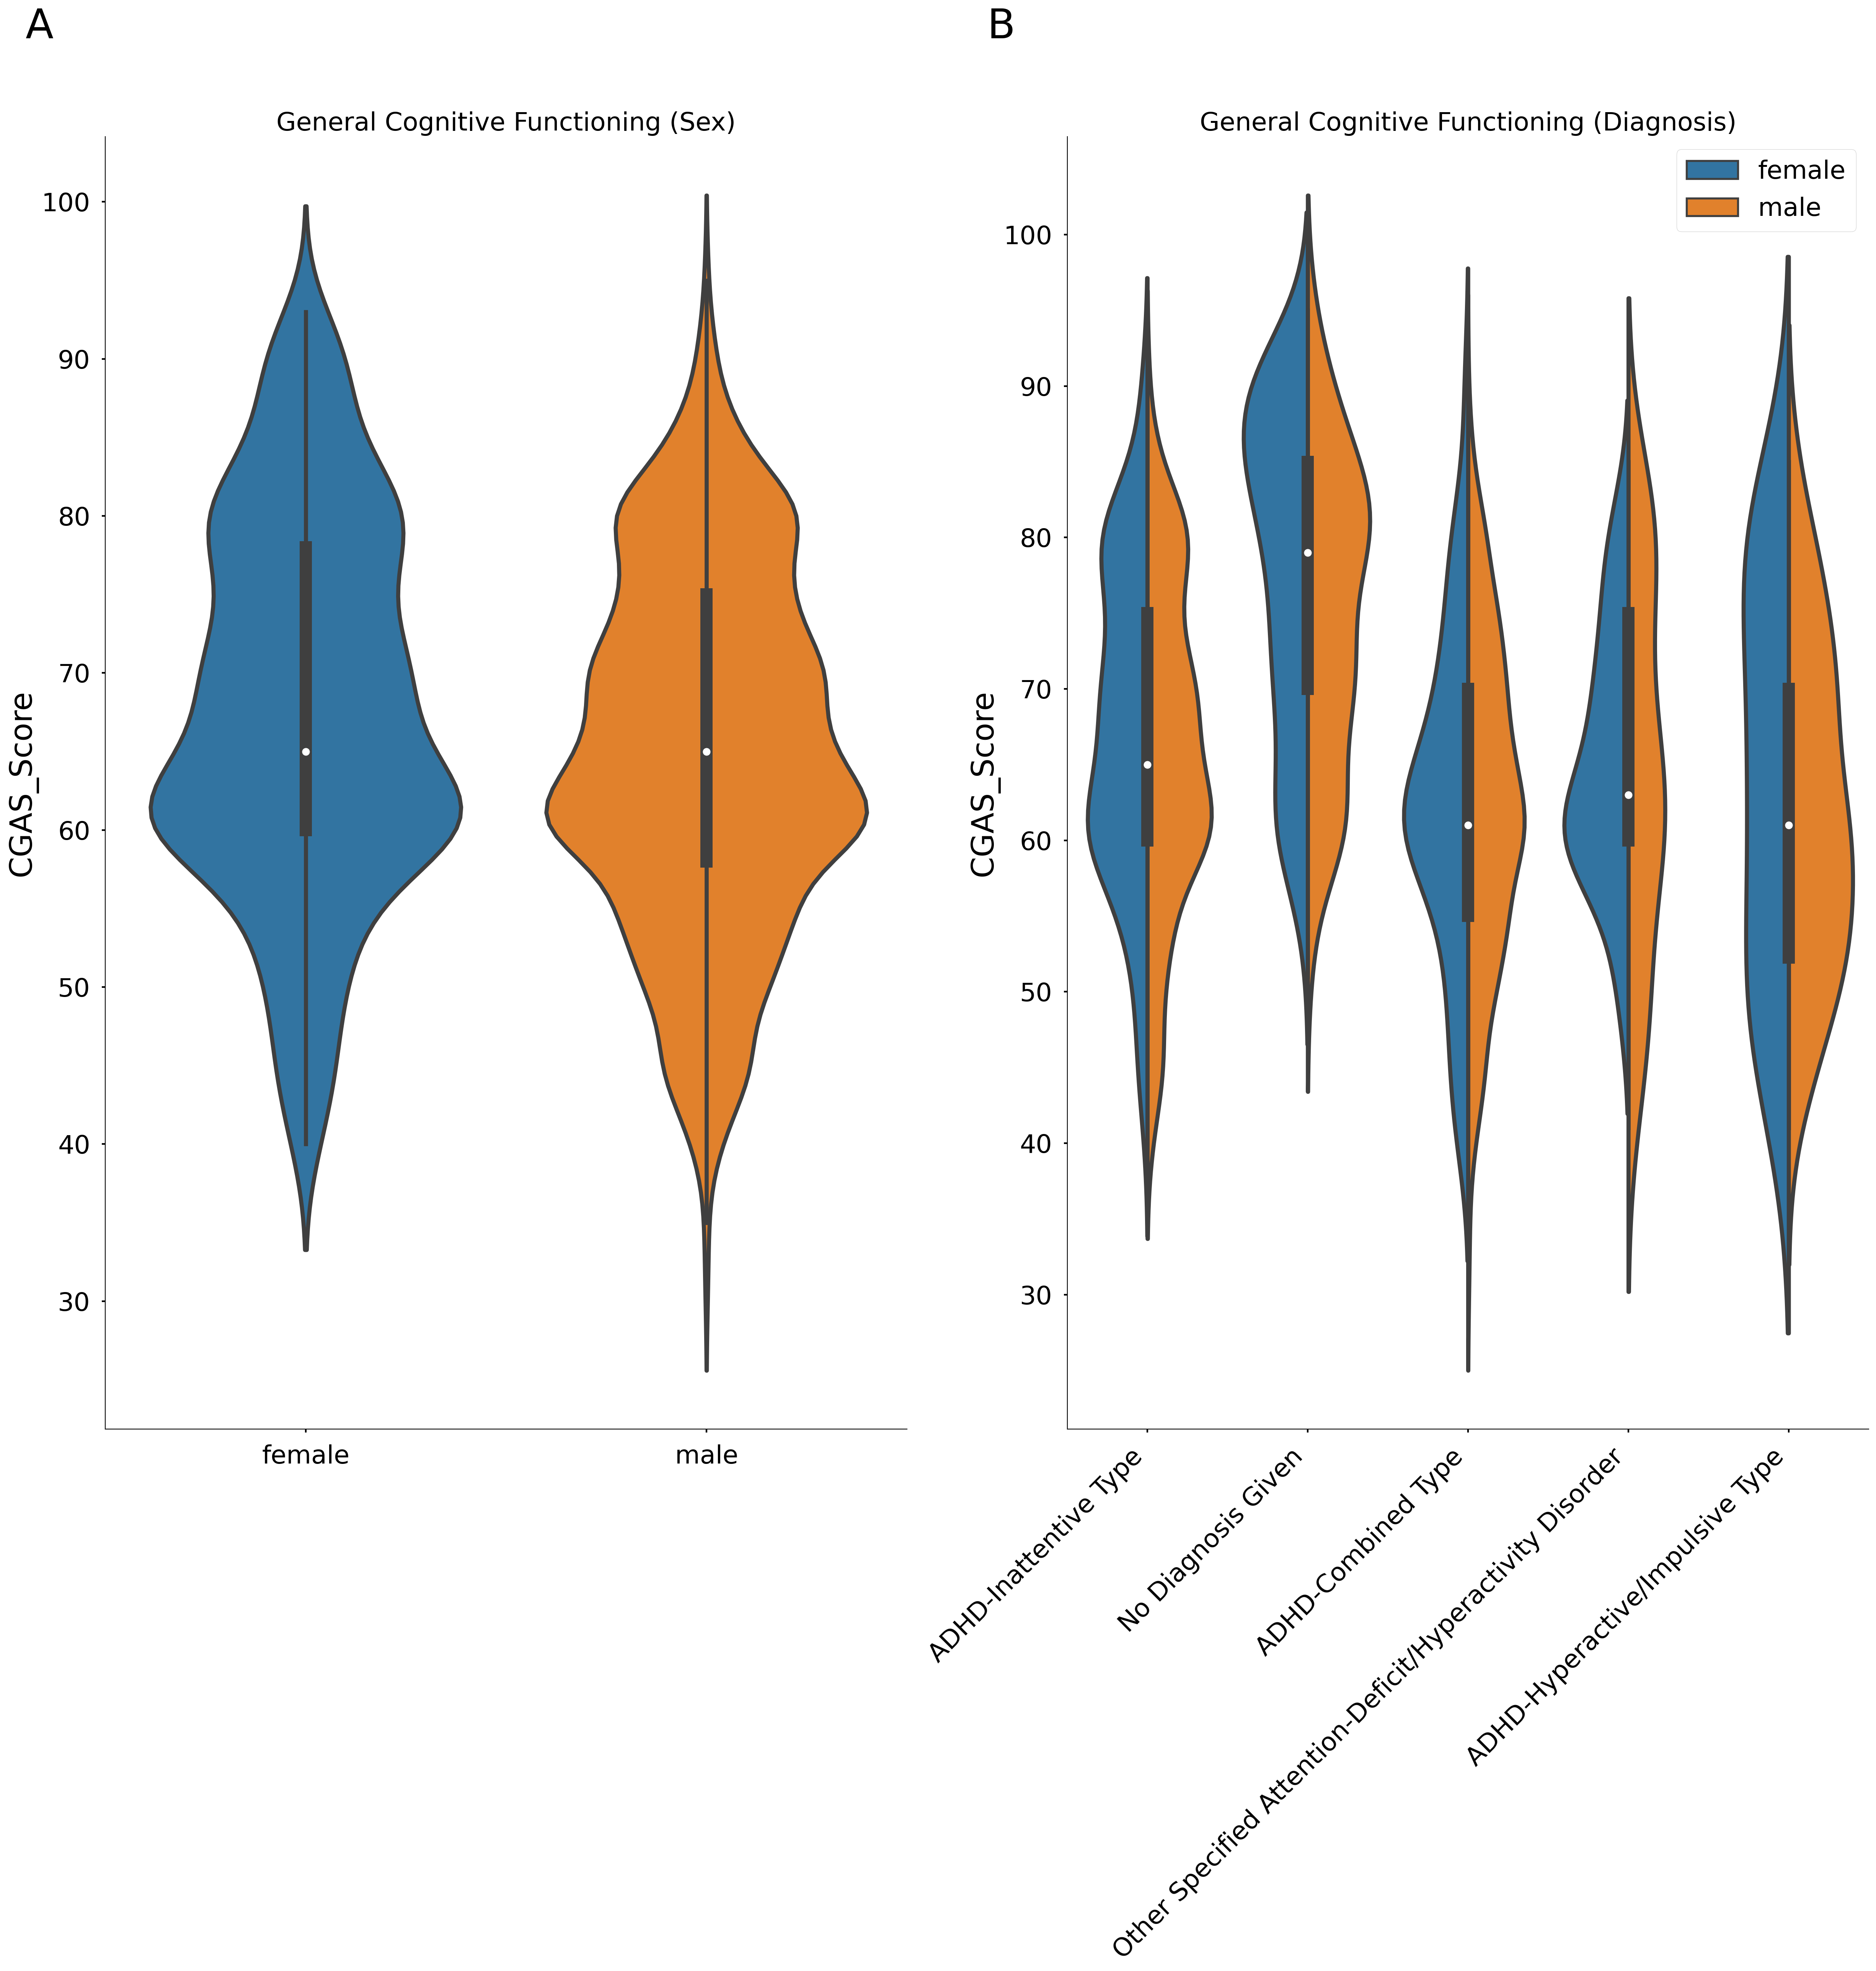

In [9]:
plt.clf()
vis.plotting_style()
x_pos = -0.1
y_pos = 1.1
labelsize = 40

fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0,0])
ax = sns.violinplot(data=df_CGAS, x='Sex', y='CGAS_Score', ax=ax)
ax.set_xlabel('')
ax.set_title('General Cognitive Functioning (Sex)')
ax.text(x_pos, y_pos, 'A', transform=ax.transAxes, fontsize=labelsize, verticalalignment='top')

ax = fig.add_subplot(gs[0,1])
ax = sns.violinplot(data=df_CGAS, x='DX_01', y='CGAS_Score', hue='Sex', split=True, ax=ax)
plt.xticks(rotation=45, ha='right');
ax.set_xlabel('')
ax.set_title('General Cognitive Functioning (Diagnosis)')
ax.text(x_pos, y_pos, 'B', transform=ax.transAxes, fontsize=labelsize, verticalalignment='top')
ax.legend_.set_title(None)

plt.subplots_adjust(left=0.125, bottom=0.001, right=2.0, top=2.0, wspace=.2, hspace=.3)


In [10]:
tmp = df_CGAS.groupby(
    ['DX_01', 'Sex'])['CGAS_Score'].agg(
    {'mean', 'std'}).reset_index().rename(
    {'mean': 'mean (CGAS)', 'std': 'std (CGAS)'}, axis=1)

head = tmp.columns.tolist()
print(tabulate(np.array(tmp), headers=head, tablefmt="grid"))

+----------------------------------------------------------+--------+--------------+---------------+
| DX_01                                                    | Sex    |   std (CGAS) |   mean (CGAS) |
+==========================================================+========+==============+===============+
| ADHD-Combined Type                                       | female |     10.7984  |       62.3455 |
+----------------------------------------------------------+--------+--------------+---------------+
| ADHD-Combined Type                                       | male   |     10.7143  |       62.2609 |
+----------------------------------------------------------+--------+--------------+---------------+
| ADHD-Hyperactive/Impulsive Type                          | female |     13.3745  |       63.8667 |
+----------------------------------------------------------+--------+--------------+---------------+
| ADHD-Hyperactive/Impulsive Type                          | male   |     10.8406  |       

## Year of Enrollment

<Figure size 1228.8x844.8 with 0 Axes>

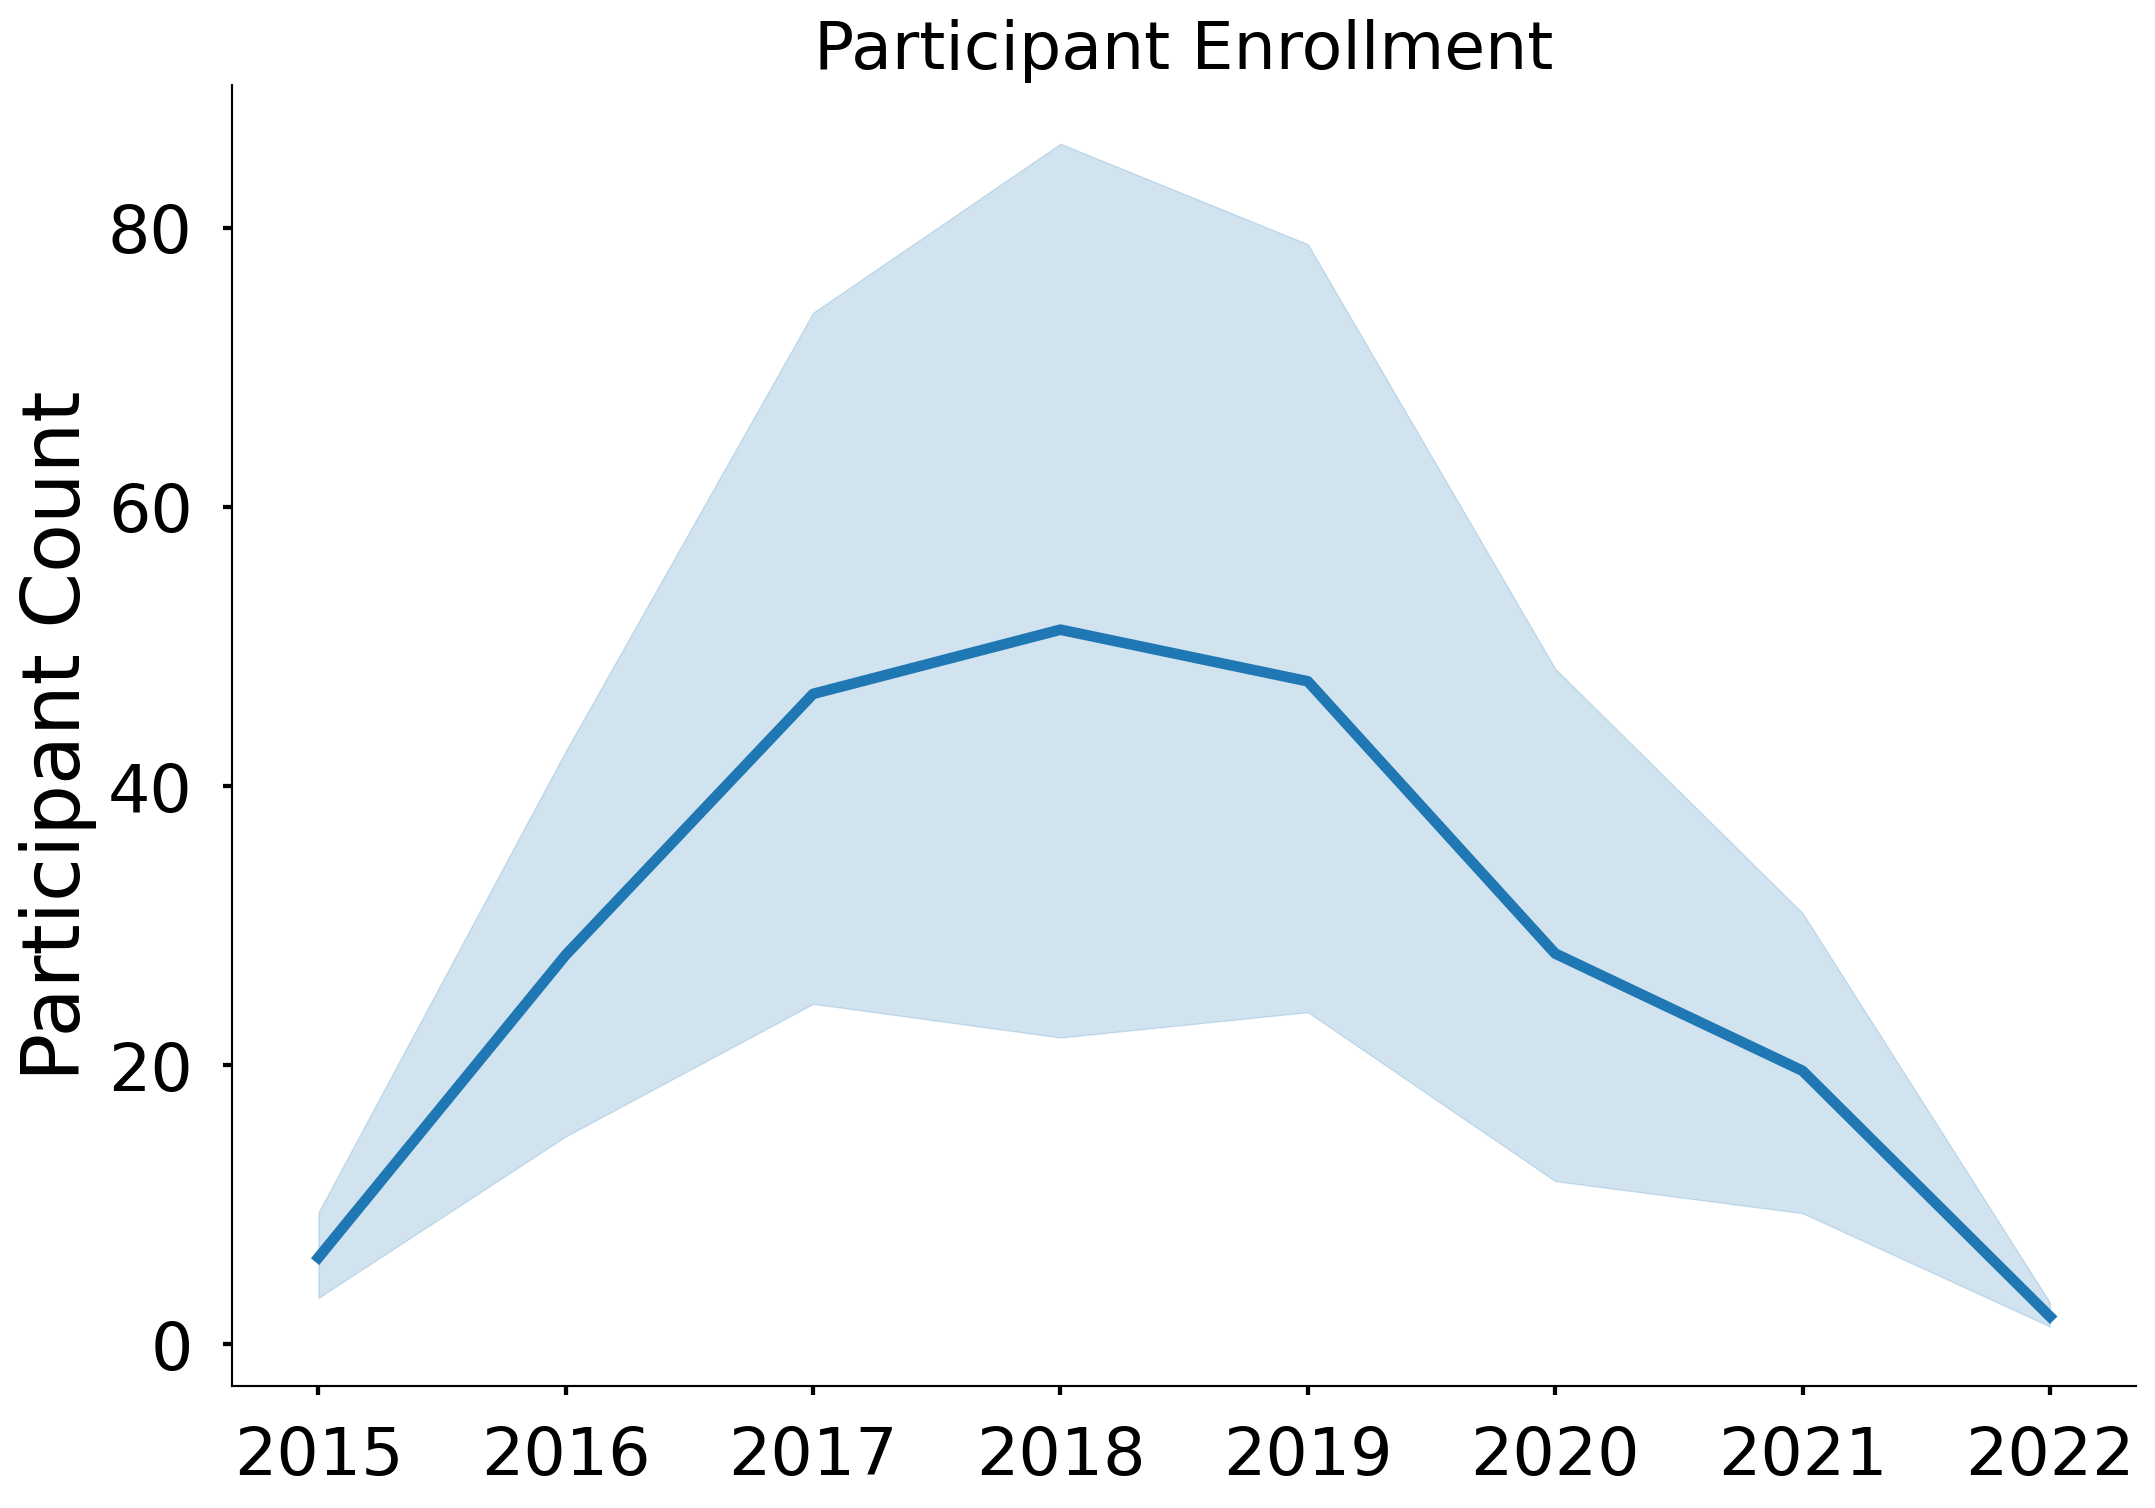

In [11]:
plt.clf()
vis.plotting_style()
x_pos = -0.1
y_pos = 1.1
labelsize = 40

fig = plt.figure()
gs = GridSpec(1, 1, figure=fig)

tmp = df.groupby(
    ['Enroll_Year', 'DX_01', 'Sex']).count()[['Identifiers']].reset_index().rename(
    {'Identifiers': 'Participant Count'}, axis=1)

ax = fig.add_subplot(gs[0,0])
ax = sns.lineplot(data=tmp, x='Enroll_Year', y='Participant Count', ax=ax)
ax.set_xlabel('')
ax.set_title('Participant Enrollment');

In [12]:
tmp = df.groupby(
    ['Enroll_Year', 'DX_01', 'Sex']).count()[['Identifiers']].reset_index().rename(
    {'Identifiers': 'Participant Count'}, axis=1)

head = ['Enrollment Year', 'Diagnosis', 'Sex', '# of Participants']
print(tabulate(np.array(tmp), headers=head, tablefmt="grid"))


+-------------------+----------------------------------------------------------+--------+---------------------+
|   Enrollment Year | Diagnosis                                                | Sex    |   # of Participants |
+===================+==========================================================+========+=====================+
|              2015 | ADHD-Combined Type                                       | female |                   4 |
+-------------------+----------------------------------------------------------+--------+---------------------+
|              2015 | ADHD-Combined Type                                       | male   |                  15 |
+-------------------+----------------------------------------------------------+--------+---------------------+
|              2015 | ADHD-Hyperactive/Impulsive Type                          | male   |                   1 |
+-------------------+----------------------------------------------------------+--------+---------------